Used for test SHAP value: based on the selected ASVs, most of which are indicators of Non burn soil (which means if it has a higher abundance then it is a not burn soil; these ASV will decrease if it get burned); the only ASV we found will increase if get burned is ASV7.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-03-06 15:52:27.443209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 15:52:27.445220: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:52:27.448444: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:52:27.458621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741294347.476587  599831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741294347.48

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

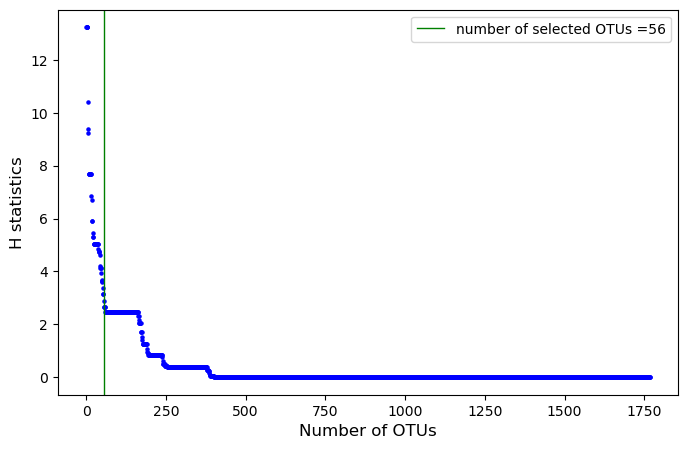

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,burn_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [8]:
iter =30


In [9]:

targetLabel=burn_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list

X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)

X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
xlabel_FS_lasso_ft = selectedOTU_index_list[xlabel_FS_lasso_ft0]

xlabel_lasso_FS = np.intersect1d(xlabel_lasso_ft, selectedOTU_index_list)
X_lasso_FS = data[:,xlabel_lasso_FS]

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft,
               "Lassofinetune_FS":X_lasso_FS
               #"Random":data
              }

The response variable and its counts are:
Burn
Yes    42
No     17
Name: count, dtype: int64


NameError: name 'RunML_continue' is not defined

In [ ]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))
print(f'The shape of the Lasso_finetune_FS selected dataset is ',np.shape(X_lasso_FS))

In [ ]:
print(xlabel_lasso_ft)
print(xlabel_lasso_FS)

In [ ]:
# compute SHAP for FS_Lassofinetune RF model

result_rf = RunML.RF_model_SCV(X_FS_lasso_ft, y=targetLabel, plot=True,columnnames= ASVs[xlabel_FS_lasso_ft],SMOTE=True)


In [ ]:
result_rf_lasso = RunML.RF_model_SCV(X_lasso_ft, y=targetLabel,plot=True,columnnames= ASVs[xlabel_lasso_ft], SMOTE=True)

In [ ]:
# Convert arrays to sets
set1 = set(ASVs[xlabel_FS_lasso_ft])
set2 = set(ASVs[xlabel_lasso_ft])

# Elements in both arrays (intersection)
common_elements = set1 & set2  # OR set1.intersection(set2)

# Elements only in one of the arrays (symmetric difference)
unique_elements = set1 ^ set2  # OR set1.symmetric_difference(set2)

print("Elements in both arrays:", common_elements)
print("Elements in only one of the arrays:", unique_elements)

In [ ]:
import shap
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First SHAP summary plot
plt.sca(axes[0])  # Set current axis to the first subplot
shap.summary_plot(result_rf['SHAP'], pd.DataFrame(result_rf['x_true'], columns=ASVs[xlabel_FS_lasso_ft]),show=False)
axes[0].set_title("FS-Lasso SHAP Summary")

# Second SHAP summary plot
plt.sca(axes[1])  # Set current axis to the second subplot
shap.summary_plot(result_rf_lasso['SHAP'], pd.DataFrame(result_rf_lasso['x_true'], columns=ASVs[xlabel_lasso_ft]),show=False)
axes[1].set_title("Lasso SHAP Summary")

plt.tight_layout()
plt.show()

In [ ]:
# analyzing ASV 191


# make interaction plot.
# when there is no 191, if the value of 216 is low then there is more likelt the soil is burned
# when there is 191 and 216 is none, there is more likely the soil is not burn, and t
shap.dependence_plot('ASV191', result_rf['SHAP'], pd.DataFrame(result_rf['x_true'], columns=ASVs[xlabel_FS_lasso_ft]), interaction_index="ASV216")


In [ ]:
# make interaction plot.
# if there is 
shap.dependence_plot('ASV7', result_rf['SHAP'], pd.DataFrame(result_rf['x_true'], columns=ASVs[xlabel_FS_lasso_ft]), interaction_index="ASV191")
shap.dependence_plot('ASV8', result_rf['SHAP'], pd.DataFrame(result_rf['x_true'], columns=ASVs[xlabel_FS_lasso_ft]), interaction_index="ASV191")
shap.dependence_plot('ASV141', result_rf['SHAP'], pd.DataFrame(result_rf['x_true'], columns=ASVs[xlabel_FS_lasso_ft]), interaction_index="ASV191")

In [ ]:
FS_lasso_df = pd.DataFrame(result_rf['x_true'], columns=ASVs[xlabel_FS_lasso_ft])

# Get the indices where array1 is not zero
indices = np.where(FS_lasso_df['ASV191'] != 0)

ASV191_df = FS_lasso_df.loc[indices]
SHAP_ASV191 = result_rf['SHAP'][indices]

In [ ]:
shap.initjs()# base line is induced
shap.force_plot(0.49, SHAP_ASV191[1,:], ASV191_df.iloc[1])

In [ ]:
indices

In [ ]:
shap.force_plot(0.49, SHAP_ASV191[0,:], ASV191_df.iloc[0])

In [ ]:
np.array(result_rf['y_pred_prob'])[indices[0]]

In [ ]:
np.array(result_rf['y_pred'])[indices[0]]

In [ ]:
np.array(result_rf['y_true'])[indices[0]]